# Featurize audio recordings

Take the trained Pann SED model and use the output of an intermediate linear layer to generate features for an unseen data set (sound recordings).  We will focus on sound recordings that were classified as 'no call', those that are not recognized as any animal sound.

These features can be clustered or fed to unsupervised learning to help label them.

Guesses of new classes include natural sounds (wind, rain, thunder, leaves rustling), motors( planes, cars, trucks, boats, equipment), people (talking, walking, music, gunshots), animals( crickets, domestic)

## Using PANN SED model

See: 
* PANN source https://github.com/qiuqiangkong/audioset_tagging_cnn/

* https://github.com/FaithKaixuan/German_Birdcall_Classification_PANNs_CNNseries/blob/master/Results%20Analysis/Germany_Birdcall_Engine_nonemixup.ipynb

* Usage Example https://github.com/yinkalario/Sound-Event-Detection-AudioSet


## Project setup

In [8]:
from pathlib import Path
import os

project_base = "/media/SSD/Sound Detection/"
results_folder = "Results"
data_folder = "birdclef-2021/train_short_audio"
model_folder = "models"

model_name_base = "pann-test-other"

In [9]:
data_path = Path(project_base)
print(data_path)

/media/SSD/Sound Detection


### Experiment documentation

In [10]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);



<IPython.core.display.Javascript object>

In [11]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /Sound/Featurize recordings-PANN-SED-1A-other animals.ipynb


In [12]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder, nb_path.stem)
print(result_path)
os.makedirs(result_path, exist_ok=True)

/Sound/Featurize recordings-PANN-SED-1A-other animals.ipynb
/media/SSD/Sound Detection/Results/Featurize recordings-PANN-SED-1A-other animals


In [13]:
model_out_path = Path(project_base) / model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/Sound Detection/models


In [14]:
#Improved CUDA debugging
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [15]:
import torch
import pandas as pd
import torchaudio


In [7]:


import numpy as np

Ideas
* Convert dataframe into sqlite in memory database for faster training
* Convert dataframe to numpy array for faster training


In [16]:
from sound_utils import SoundDisplay

## Handle Metadata

In [17]:
df = pd.read_csv('/media/SSD/Sound Detection/combined_train_metadata.csv',index_col=[0])
df1 = pd.read_csv('/media/SSD/Sound Detection/other-animals/american-toad/train_metadata.csv',index_col=[0])
df2 = pd.read_csv('/media/SSD/Sound Detection/other-animals/chipmunk/train_metadata.csv',index_col=[0])
df3 = pd.read_csv('/media/SSD/Sound Detection/other-animals/coyote/train_metadata.csv',index_col=[0])
df4 = pd.read_csv('/media/SSD/Sound Detection/other-animals/green-frog/train_metadata.csv',index_col=[0])
df5 = pd.read_csv('/media/SSD/Sound Detection/other-animals/spring-peeper/train_metadata.csv',index_col=[0])
df6 = pd.read_csv('/media/SSD/Sound Detection/other-animals/western-chorus-frog/train_metadata.csv',index_col=[0])
df7 = pd.read_csv('/media/SSD/Sound Detection/other-animals/wood-frog/train_metadata.csv',index_col=[0])
df = pd.concat([df, df1, df2, df3, df4, df5, df6, df7], ignore_index=True, sort=True)                  

/media/SSD/conda_env/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (2,6,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Handle class labels

In [18]:
keys = pd.read_csv('/media/SSD/Sound Detection/label_metadata.csv',index_col=[0])
keys1 = pd.read_csv('/media/SSD/Sound Detection/other-animals/american-toad/key.csv',index_col=[0])
keys2 = pd.read_csv('/media/SSD/Sound Detection/other-animals/chipmunk/key.csv',index_col=[0])
keys3 = pd.read_csv('/media/SSD/Sound Detection/other-animals/coyote/key.csv',index_col=[0])
keys4 = pd.read_csv('/media/SSD/Sound Detection/other-animals/green-frog/key.csv',index_col=[0])
keys5 = pd.read_csv('/media/SSD/Sound Detection/other-animals/spring-peeper/key.csv',index_col=[0])
keys6 = pd.read_csv('/media/SSD/Sound Detection/other-animals/western-chorus-frog/key.csv',index_col=[0])
keys7 = pd.read_csv('/media/SSD/Sound Detection/other-animals/wood-frog/key.csv',index_col=[0])
keys = pd.concat([keys, keys1, keys2, keys3, keys4, keys5, keys6, keys7], ignore_index=True)

In [19]:
with pd.option_context('display.max_rows', None,'display.max_columns', None,):
    display(keys)

common_name primary_label  \
0                  Acadian Flycatcher        acafly   
1                    Acorn Woodpecker        acowoo   
2                    Alder Flycatcher        aldfly   
3                     American Avocet        ameavo   
4                       American Crow        amecro   
5                  American Goldfinch        amegfi   
6                    American Kestrel        amekes   
7                      American Pipit        amepip   
8                   American Redstart        amered   
9                      American Robin        amerob   
10                    American Wigeon        amewig   
11              American Tree Sparrow        amtspa   
12                   Andean Solitaire       andsol1   
13                 Anna's Hummingbird        annhum   
14            Ash-throated Flycatcher        astfly   
15                  Azara's Spinetail       azaspi1   
16               Bay-breasted Warbler        babwar   
17                         Bald Eagle        baleag   
18                   Baltimore Oriole        balori   
19                         Bananaquit        banana   
20                       Bank Swallow        banswa   
21                        Banded Wren       banwre1   
22                   Barred Antshrike       barant1   
23                       Barn Swallow        barswa   
24                 Band-tailed Pigeon       batpig1   
25             Blue-and-white Swallow       bawswa1   
26            Black-and-white Warbler        bawwar   
27                           Bay Wren       baywre1   
28       Black-bellied Whistling-Duck        bbwduc   
29          Black-crowned Night-Heron        bcnher   
30                  Belted Kingfisher       belkin1   
31                       Bell's Vireo        belvir   
32                      Bewick's Wren        bewwre   
33                Black-billed Magpie       bkbmag1   
34               Black-bellied Plover        bkbplo   
35               Blackburnian Warbler        bkbwar   
36             Black-capped Chickadee        bkcchi   
37              Black-headed Grosbeak        bkhgro   
38             Yellow-throated Toucan       bkmtou1   
39                 Black-necked Stilt        bknsti   
40               Blue-black Grassquit       blbgra1   
41                Black-billed Thrush       blbthr1   
42                  Black-chested Jay       blcjay1   
43               Black-capped Tanager       blctan1   
44                 Blue-headed Parrot       blhpar1   
45                       Black Phoebe        blkpho   
46              Black-striped Sparrow       blsspa1   
47                      Blue Grosbeak       blugrb1   
48                           Blue Jay        blujay   
49           Brown-crested Flycatcher        bncfly   
50               Brown-headed Cowbird        bnhcow   
51             Boat-billed Flycatcher       bobfly1   
52                   Bonaparte's Gull        bongul   
53                Boat-tailed Grackle        botgra   
54                Broad-billed Motmot       brbmot1   
55             Brown-backed Solitaire       brbsol1   
56                 Brown-capped Vireo       brcvir1   
57                 Brewer's Blackbird        brebla   
58                      Brown Creeper        brncre   
59                          Brown Jay        brnjay   
60                     Brown Thrasher        brnthr   
61               Bright-rumped Attila       brratt1   
62                  Broad-winged Hawk        brwhaw   
63               Bronze-winged Parrot       brwpar1   
64        Black-throated Blue Warbler        btbwar   
65       Black-throated Green Warbler        btnwar   
66        Black-throated Gray Warbler        btywar   
67                    Lesson's Motmot       bucmot2   
68              Blue-gray Gnatcatcher        buggna   
69                  Blue-gray Tanager        bugtan   
70                  Blue-headed Vireo        buhvir   
71                   Bullock's Oriole        bulori   
72         

In [20]:
from sound_utils import DatasetUtils

In [21]:
DatasetUtils.sound_lookup(keys,'rthhum')

('Ruby-throated Hummingbird', 'Archilochus colubris')

In [22]:
DatasetUtils.sound_idn(keys,'no_call')

220

In [23]:
DatasetUtils.sound_common(keys,220)

'No Call'

## Define the network

In [24]:
from sound_utils import NN

In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [26]:
model = NN.Cnn14_DecisionLevelAtt(classes_num=len(keys))


In [27]:
# build a new model

resample = torchaudio.transforms.Resample(32000, 48000)

spec = torchaudio.transforms.MelSpectrogram(sample_rate=48000,
                                            n_fft=768,
                                            n_mels=80,
                                            f_min=200,
                                            f_max=10000)
a_to_db = torchaudio.transforms.AmplitudeToDB()
#new_model = nn.Sequential(resample,spec,model)
new_model = nn.Sequential(resample, spec, a_to_db, model)

In [28]:
#for param in new_model.parameters():
#    param.requires_grad = False

In [29]:
new_model.cuda();

In [30]:
model_out_str = str(model_out_path/(model_name_base+"3.pth"))
new_model.load_state_dict(torch.load(model_out_str),strict = False)


_IncompatibleKeys(missing_keys=['0.kernel'], unexpected_keys=[])

In [31]:
new_model.eval();

In [32]:
new_model

Sequential(
  (0): Resample()
  (1): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (2): AmplitudeToDB()
  (3): Cnn14_DecisionLevelAtt(
    (bn0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): Batc

In [33]:
from tqdm.notebook import tqdm

## Get features for a data set

In [34]:

directory = "/media/HDD/Audio Recordings/Cabin"   
#directory = "/media/HDD/Audio Recordings/Vadnais" 

### get predictions from prior inference on this data set
Use the timestamp for predictions of the no_call data to generate the feature vector using the trained network.

In [35]:
birds_df = pd.read_csv('/media/SSD/Sound Detection/Results/Predict recordings-PANN-SED-1A-other animals/cabin_birds_df.csv',index_col=[0])

In [36]:
#no_call_df = birds_df[birds_df.bird_key == 'no_call']
no_call_df = birds_df[(birds_df.bird_key == 'no_call') & (birds_df.maxprob >.5)]

In [50]:
new_model[0] = torchaudio.transforms.Resample(48000,48000) # set to sample rate of 48000 for this input data

### Add a hook to the model to capture the output of the linear feature layer

In [51]:
new_model[3].fc1
#new_model[3].conv_block6.conv2

Linear(in_features=2048, out_features=2048, bias=True)

In [52]:
# Define a foreward hook to get an activation
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5
# https://stackoverflow.com/questions/52796121/how-to-get-the-output-from-a-specific-layer-from-a-pytorch-model

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [53]:
#new_model[3].fc1.register_forward_hook(get_activation('fc1'))
handle = new_model[3].fc1.register_forward_hook(get_activation('fc1'))

In [ ]:
# How to remove the handle
#handle.remove()

### Predict at clip
Test some stuff out to make sure its working

In [41]:
pdx = 2000 #pick a row at random
w = 5 # 5 second samples
sr = 48000
row = no_call_df.iloc[pdx]

In [42]:
len(no_call_df)

27334

In [43]:
row.file, row.time, row.maxprob

('/media/HDD/Audio Recordings/Cabin/Cabin Aug 28 2021/Late summer Night-2021-08-29--01-24-25-6.flac',
 856.0526315789474,
 0.9989805817604064)

In [44]:
#load the sound sample
x, sr = torchaudio.load(row["file"],int((row['time']) * sr),5 * sr) # this normalizes the sound

In [45]:
x[0].shape

torch.Size([240000])

In [46]:
SoundDisplay.play_audio(x,sr)

In [55]:
x = x.cuda()
with torch.no_grad():
    output = new_model(x[0].unsqueeze(0).unsqueeze(0))

In [94]:
k=2
top_k_clip = output['clipwise_output'][0].topk(k)

top_k_frame = output['framewise_output'][0].topk(1)

from functools import partial

bird_common = partial(DatasetUtils.sound_common,keys)

print("Clipwise Prediction Info")
#print(top_k_clip.values)
print(bird_common(top_k_clip.indices.cpu()))

probs = top_k_frame.values.cpu().flatten().tolist()
labels = list(map(bird_common,top_k_frame.indices.cpu()))
q=list(zip(probs,labels))

print("Framewise Prediction Info")
print(q)

Clipwise Prediction Info
220                      No Call
29     Black-crowned Night-Heron
Name: common_name, dtype: object
Framewise Prediction Info
[(0.81269770860672, 220    No Call
Name: common_name, dtype: object), (0.9256960153579712, 220    No Call
Name: common_name, dtype: object), (0.9583964943885803, 220    No Call
Name: common_name, dtype: object), (0.9411831498146057, 220    No Call
Name: common_name, dtype: object), (0.9465599060058594, 220    No Call
Name: common_name, dtype: object), (0.9673271775245667, 220    No Call
Name: common_name, dtype: object), (0.9868314266204834, 220    No Call
Name: common_name, dtype: object), (0.9892181158065796, 220    No Call
Name: common_name, dtype: object), (0.9870457649230957, 220    No Call
Name: common_name, dtype: object), (0.9661270976066589, 220    No Call
Name: common_name, dtype: object), (0.9159501791000366, 220    No Call
Name: common_name, dtype: object), (0.854780375957489, 220    No Call
Name: common_name, dtype: object), 

In [56]:
activation.keys()

dict_keys(['fc1'])

In [57]:
# activation is 19x2048.  The 19 reflects the frames in the audio sample that are the attention buckets.
# Each reflects roughly 1/19 of the 5 second sound sample or 0.26 seconds of the sample.
# The 2098 represent the features.
activation['fc1'].squeeze(0).cpu().shape

torch.Size([19, 2048])

In [60]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]

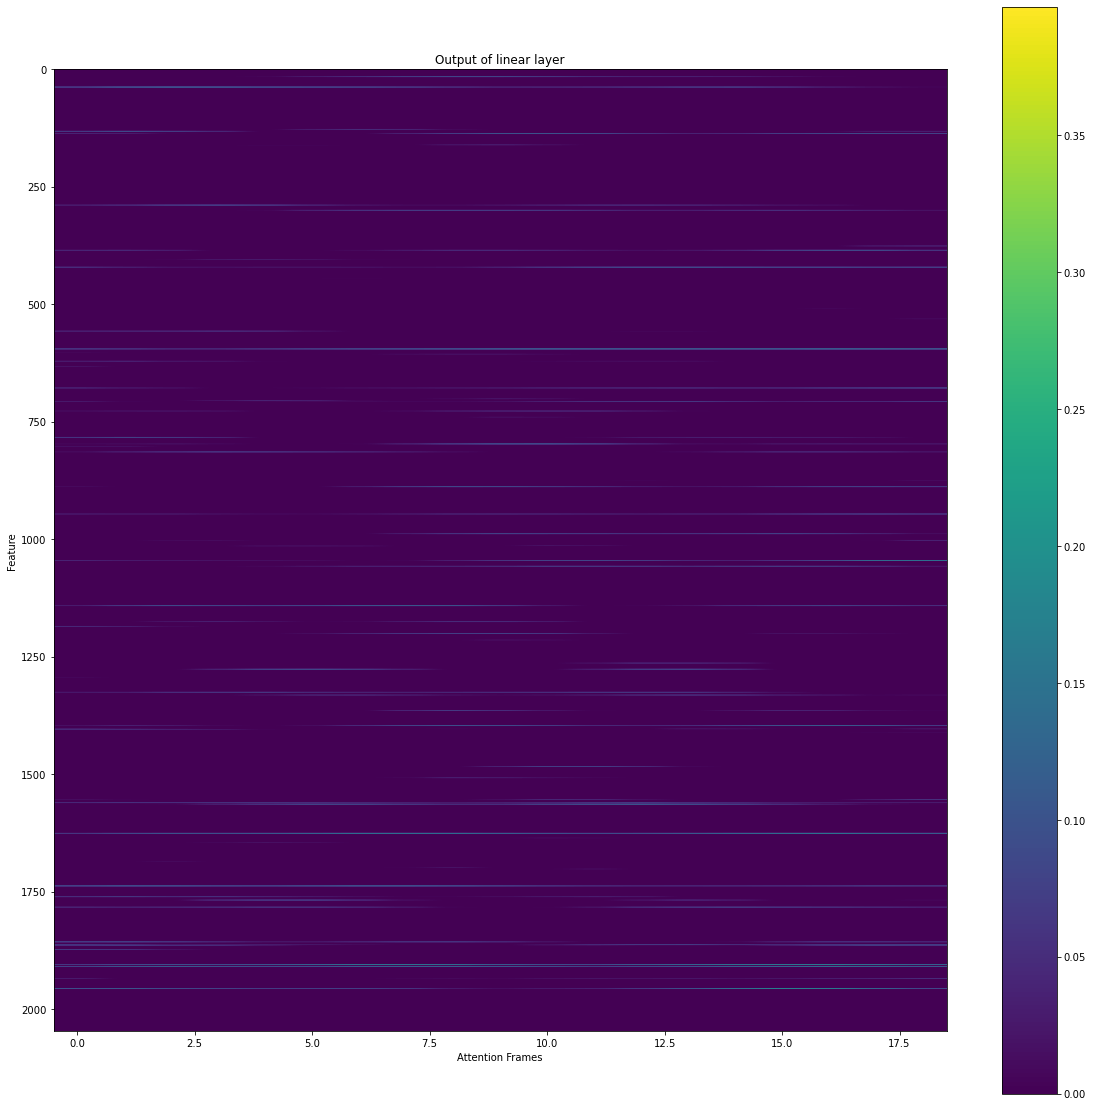

In [65]:

plt.imshow(activation['fc1'].squeeze(0).cpu().numpy().transpose(), aspect=1/100)
plt.colorbar()
plt.title('Output of linear layer')
plt.xlabel('Attention Frames')
plt.ylabel('Feature')
plt.show()

#### Features are sparse
why are the features so sparse?  I believe its due to the use of dropout during training, which encourages sparsity - but the weights are not as sparse.



In [64]:
new_model[3].fc1.weight.shape

torch.Size([2048, 2048])

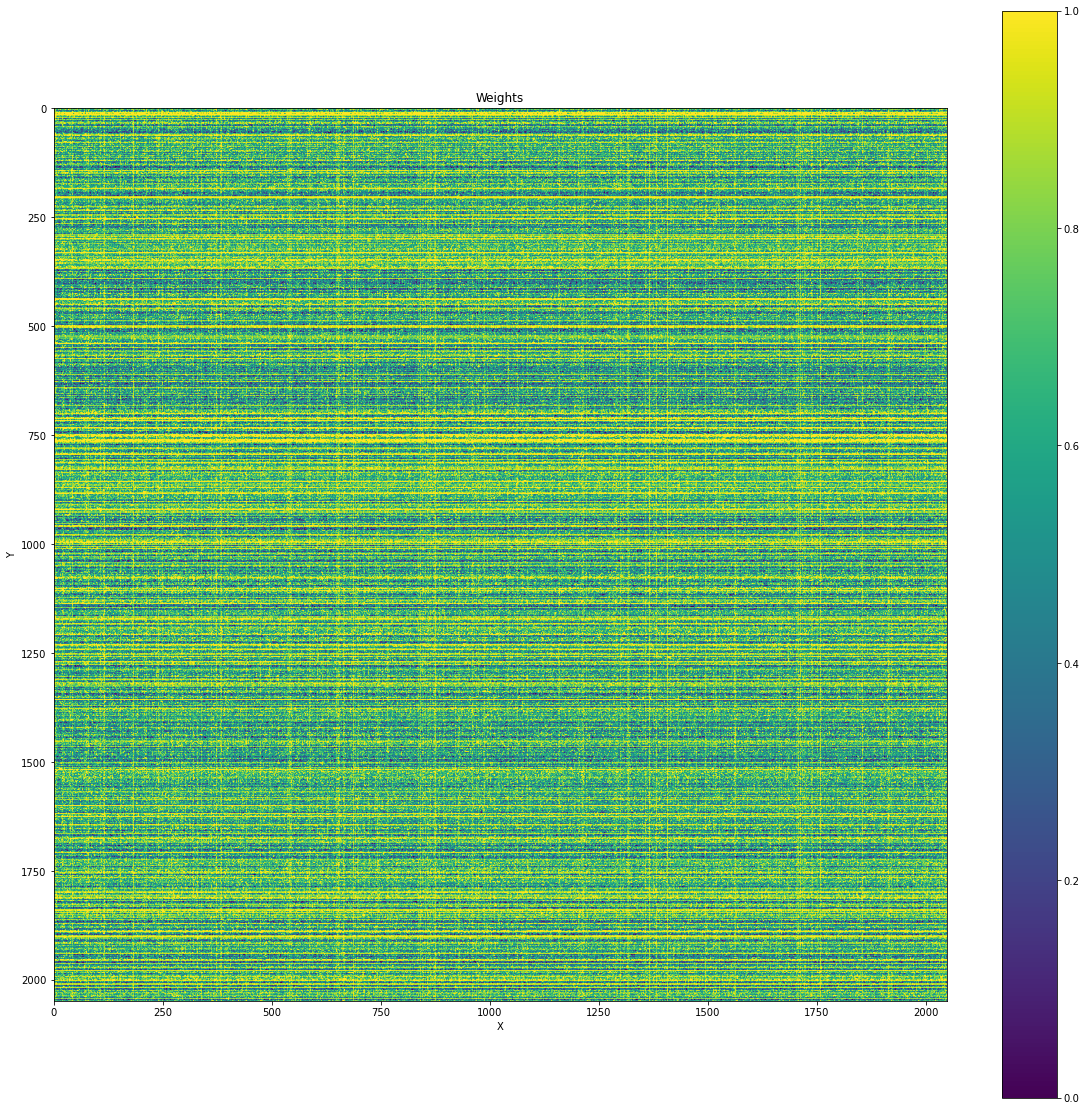

In [80]:
plt.imshow(abs(new_model[3].fc1.weight.detach().cpu().numpy()) < 0.1)
plt.colorbar()
plt.title('Weights')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

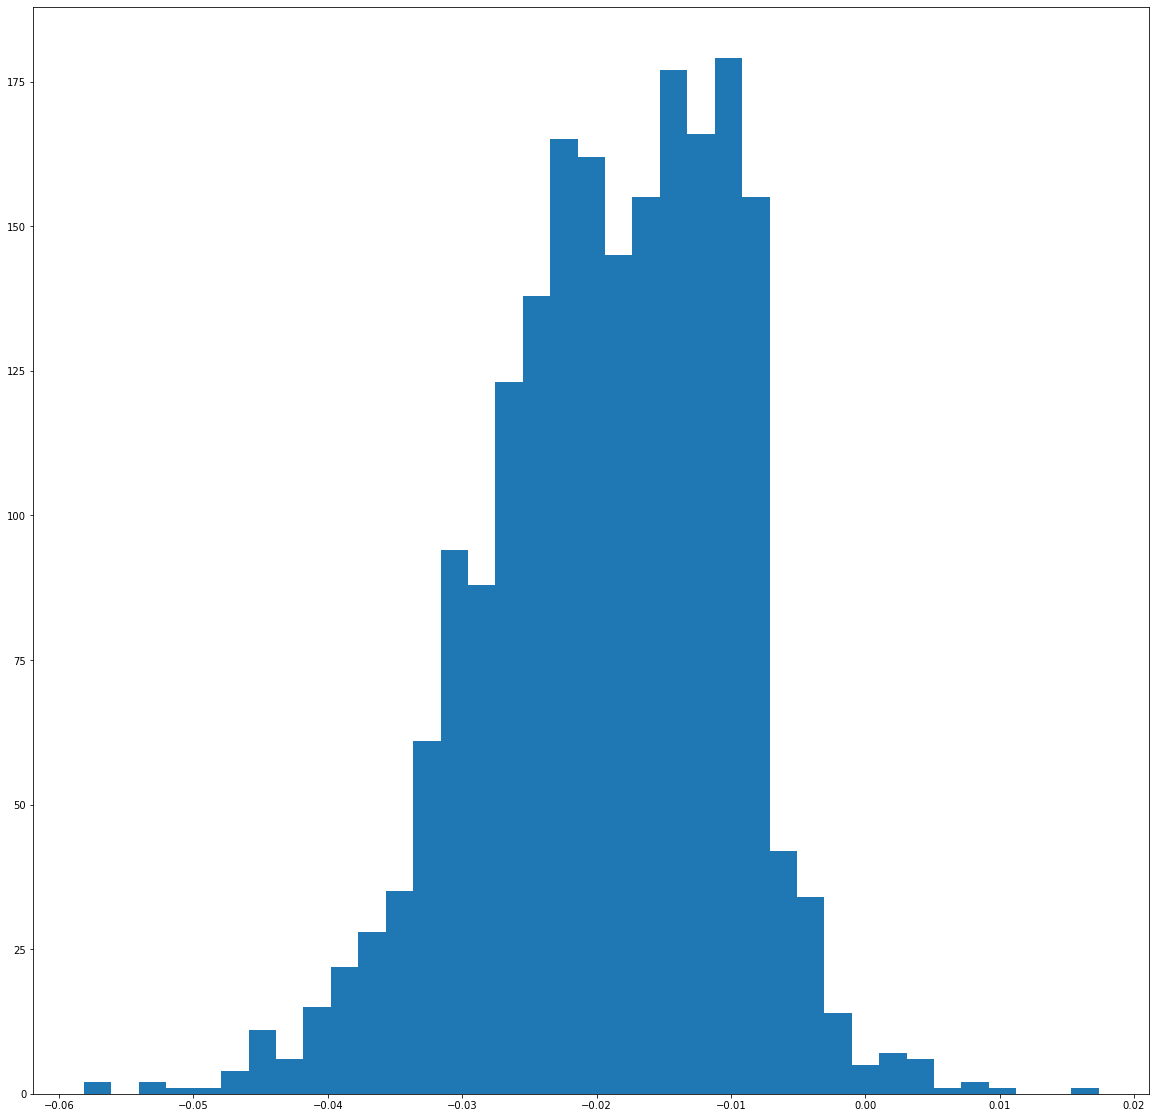

In [93]:
plt.hist(new_model[3].fc1.weight.detach().cpu().numpy().mean(axis=1), bins='auto')
plt.show()

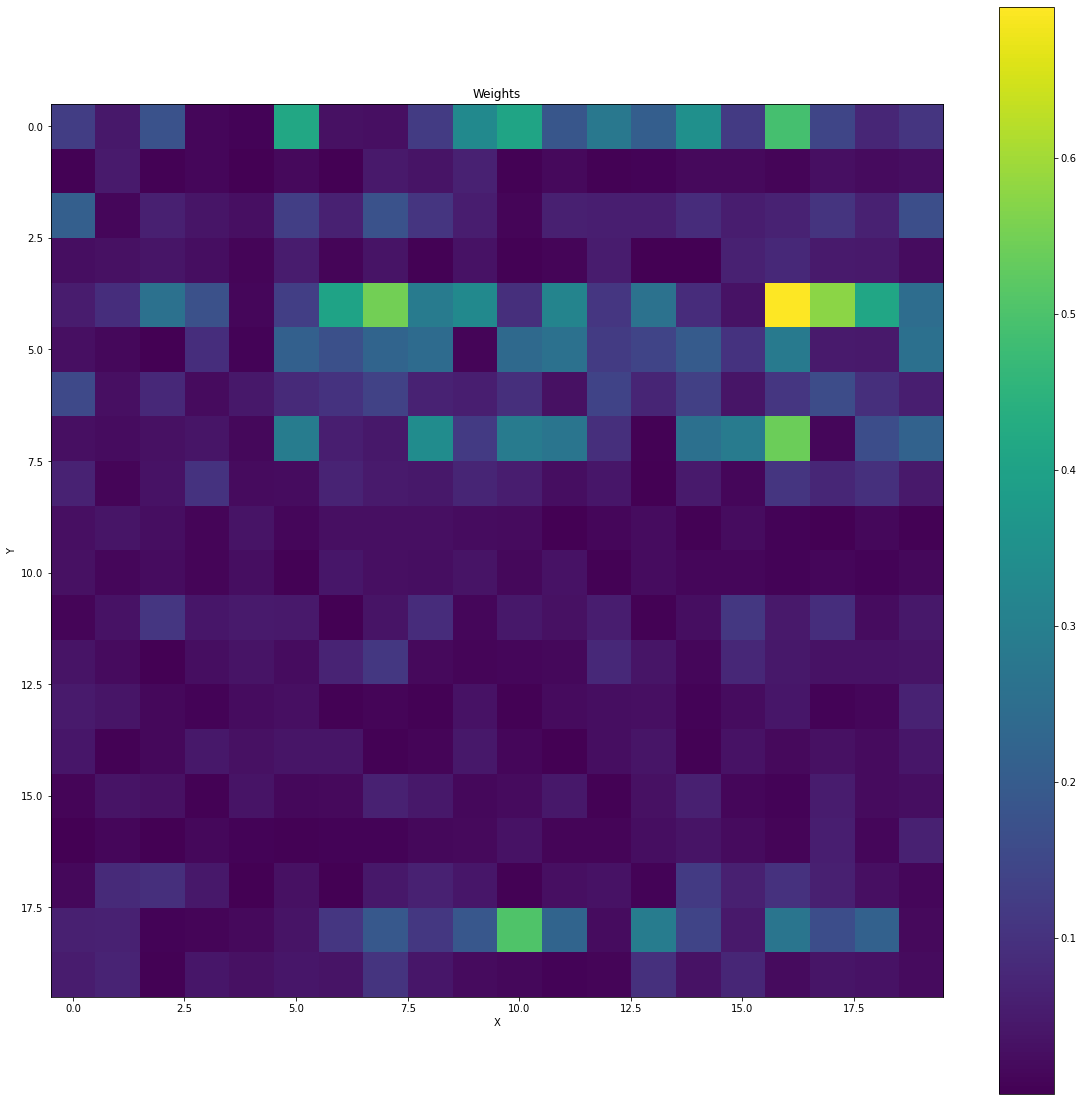

In [90]:
plt.imshow(abs(new_model[3].fc1.weight[0:20,0:20].detach().cpu().numpy()))
plt.colorbar()
plt.title('Weights')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Generate the feature data from samples

### Steps to Generate feature data for each time stamp
1. Loop by time stamp
2. Start at timestamp and end at timestamp + 5 sec to create a sample
3. generate feature data and save as a file (or in a list)


In [ ]:

w = 5 # 5 second samples
sr = 48000
channel = 2
p_level = 0.5
no_call_index = DatasetUtils.sound_idn(keys,'no_call')

l = len(no_call_df)

#set up storage in advance - space needed will be less than this
data = np.zeros((l*19,2048))
data_ids = np.zeros(l*19,dtype=int)

it = 0
last_fn = ""

for pdx in tqdm(range(0,l)):
    row = no_call_df.iloc[pdx]
    #print(pdx,":",row.file, row.time, row.maxprob)

    #x, sr = torchaudio.load(row["file"],int((row['time']) * sr),5 * sr) # this normalizes the sound
    if last_fn != row.file:
        test_data, sr = torchaudio.load(row["file"])
        last_fn = row["file"]
        
        
    i = int((row['time']) * sr)    
    x = test_data[0,i:i+sr*w]
    x = x.cuda()
    with torch.no_grad():
        output = new_model(x.unsqueeze(0).unsqueeze(0))
        
    res = activation['fc1'].squeeze(0).cpu().numpy()
    
    top_k_frame = output['framewise_output'][0].topk(1)
    probs = top_k_frame.values.cpu().flatten().numpy()
    indexes = top_k_frame.indices.cpu().flatten().numpy()
    #print("probs",probs,indexes)
    # Need to check that the frame prediction is a no_call in the below before we call it a feature.
    ids = np.nonzero((probs>p_level) & (indexes == no_call_index))[0]
    #ids = np.where((probs>p_level))[0]
    #print("ids",ids)
    lid = len(ids)
    #print("length:",lid)
    data[it:it+lid,:] = res[ids,:]
    data_ids[it:it+lid] = pdx
    it = it + lid


In [ ]:
data[0:it,:].shape 

In [ ]:
data = data[0:it,:]
data_ids = data_ids[0:it]

## Save the results

In [ ]:
fn_features = result_path/"features1.npy"
fn_feature_ids = result_path/"feature_ids1.npy"
fn_no_call_times = result_path/"no_call_times_df.csv"

In [ ]:
np.save(fn_features,data)
np.save(fn_feature_ids,data_ids)
no_call_df.to_csv(fn_no_call_times)

In [95]:
result_path

PosixPath('/media/SSD/Sound Detection/Results/Featurize recordings-PANN-SED-1A-other animals')